## 一、构建决策树  

### 1.计算信息熵calculate_entropy(dataset)  
$H(D)=-\sum\limits_{k=1}^K\frac{|C_k|}{|D|}log_2\frac{|C_k|}{|D|}$ 　　$\color{red}{|D|为传入样本总数，|C_k|为类C_k个数}$ 

In [ ]:
#--------------------计算信息熵(传入数据集)-----------------#
def calculate_entropy(self,dataset):
    #获得样本总数|D| 
    datanum = len(dataset)
    #获得样本标签(类别Ck)
    label=dataset.label.value_counts()
    label_arr=np.array(label.index)
    #初始化信息熵
    shannonEnt=0.0
    #计算信息熵
    for i in label_arr:
        prob = label[i]/datanum
        shannonEnt -= prob * math.log(prob, 2)          
    return shannonEnt

### 2.按某一特征划分数据集split_dataset(dataset,feature_name,feature_index,value,head_arr)   
**对于选定特征和取值，找到该特征为这个取值的所有样本，组成样本集，并删去这个特征所在的列**  
这里我传入的数据集都是DataFrame格式，由于会有递归调用并在函数处理过程中会使用到list，array，因此在返回数据集前要转化为DataFrame

In [ ]:
#--------------------划分数据集(传入数据集、划分特征名、划分特征索引、特征取值、特征集)----------------#
def split_dataset(self,dataset,feature_name,feature_index,value,head_arr):
    #获取标题头
    column=list(head_arr)
    #若标题内有待划分特征，则删除
    if(column.count(feature_name)!=0):
        column.remove(feature_name) 
    #标题头添加'label'
    column.append('label')
    #选中这个特征列
    feature_col=dataset[feature_name]
    #初始化返回数据集列表
    ret_dataset=[]
    #根据取值划分数据集
    for i in range(len(dataset)):
        if(feature_col[i]==value):
            midvar=list(dataset.iloc[i])
            remaindata=midvar[:feature_index]
            remaindata.extend(midvar[feature_index+1:])#这里的几步操作相当于删除了下标为feature_index的那一列(即删除划分特征)
            ret_dataset.append(remaindata)
    #将列表转化为dataframe
    ret_dataset=pd.DataFrame(ret_dataset,columns=column)
    return ret_dataset #返回不含划分特征的子集

### 3.按信息增益/信息增益率找最佳划分特征choose_best_feature_ID3/choose_best_feature_C45(dataset,featureArr)  
$计算每个特征的经验条件熵：H(D|A)=\sum\limits_{i=1}^n\frac{|D_i|}{|D|}H(D_i)$  
$计算信息增益(ID3)：g(D,A)=H(D)-H(D|A)$  　　　　　　$计算信息增益率(C4.5)：g(D,A)=\frac{H(D)-H(D|A)}{H_A(D)}$ 

In [ ]:
#-------------------------------------根据信息增益选择最佳特征数(ID3)，传入数据集和特征集--------------------------------------#
def choose_best_feature_ID3(self,dataset,featureArr):
        feature_num=len(dataset.iloc[0])-1 #特征数=列数-1(即减去标签那一列)
        emp_entropy=self.calculate_entropy(dataset) #计算数据集D的经验熵        
        bestInforGain=0 #初始化最大信息增益
        bestFeature='' #初始化最佳划分特征
        bestFeatureNum=-1
        

        #-------------计算每个特征对数据集的经验条件熵--------------#
        for fea_index,fea_name in enumerate(featureArr):
            featList=dataset[fea_name] #某个特征的所有取值
            uniqualVals=set(featList) #set无重复的属性特征值
            
            #初始化经验条件熵
            emp_cond_entropy=0
            head_index=np.array(featureArr)

            for value in uniqualVals:
                #对这个特征的所有可能取值进行划分数据集
                values_head=head_index
                subdataset=self.split_dataset(dataset,fea_name,fea_index,value,values_head)
                prob=len(subdataset)/float(len(dataset)) #即每个划分子集占整个子集的比例
                res=self.calculate_entropy(subdataset)
                emp_cond_entropy+=prob*res #对各子集经验熵求和得到经验条件熵
            infoGain=emp_entropy-emp_cond_entropy #计算信息增益
            #------得到最大信息增益和最佳划分特征-----#
            if (infoGain>bestInforGain):
                bestInforGain=infoGain
                bestFeature=fea_name
                bestFeatureNum=fea_index

        return bestFeature,bestFeatureNum #返回最佳划分特征值

    
#-------------------------------------根据信息增益比选择最佳特征数(C4.5)，传入数据集和特征集--------------------------------------#
def choose_best_feature_C45(self,dataset,featureArr):
        feature_num=len(dataset.iloc[0])-1#特征数
        emp_entropy=self.calculate_entropy(dataset)#计算数据集D的经验熵
        
        bestInforGain=0#初始化最大信息增益
        bestFeature=''#初始化最佳划分特征
        bestFeatureNum=-1
        

        #-------------计算每个特征对数据集的经验条件熵--------------#
        for fea_index,fea_name in enumerate(featureArr):
            featList=dataset[fea_name] #某个特征的所有取值
            uniqualVals=set(featList) #set无重复的属性特征值
            
            emp_cond_entropy=0
            splitInfo=0
            head_index=np.array(featureArr)
            
            #names = locals()
            for value in uniqualVals:
                #对这个特征的所有可能取值进行划分数据集
                values_head=head_index
                subdataset=self.split_dataset(dataset,fea_name,fea_index,value,values_head)
                prob=len(subdataset)/float(len(dataset)) #即每个划分子集占整个子集的比例
                res=self.calculate_entropy(subdataset)
                emp_cond_entropy += prob*res#self.calculate_entropy(subdataset)#对各子集经验熵求和得到经验条件熵
                splitInfo -= prob * math.log(prob,2)
            infoGain=(emp_entropy-emp_cond_entropy)/splitInfo #计算信息增益率
            #print("对于",fea_name,"特征：","条件经验熵为：",emp_cond_entropy,"信息增益为：",infoGain)
            #------得到最大信息增益和最佳划分特征-----#
            if (infoGain>bestInforGain):
                bestInforGain=infoGain
                bestFeature=fea_name
                bestFeatureNum=fea_index
        #print("最好的划分特征是：(choosebest)",bestFeature)

        return bestFeature,bestFeatureNum #返回最佳划分特征值

### 4.特征集为空，返回样本最多的类别majorityCnt(classList)  
按分类后类别数量排序,若特征集为空，则返回数据集中样本数最多的类作为节点标记，停止划分 

In [ ]:
#--------------按分类后类别数量排序(传入类别列表)----------------------#
def majorityCnt(self,classList):    
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote]+=1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)#按样本数逆序将每个类别排序
    return sortedClassCount[0][0] #返回样本数最多的类

### 5.构建决策树(递归调用)create_tree_ID3/create_tree_C45(dataset,feat_labels)

In [ ]:
#--------------构建决策树(传入数据集和特征值列表)----------------------#
def create_tree_ID3(self,dataset,feat_labels):
        classList=list(dataset['label'])#获得类别列表

        #若是所有样本属于同一类别，则返回这一类别做节点标记，停止划分
        if classList.count(classList[0])==len(classList):
            #print("该节点上所有样本为同一类")
            return classList[0]

        #若特征集为空，则返回数据集中样本数最多的类作为节点标记，停止划分
        if len(dataset.iloc[0])==1:
            #print("特征集为空")
            return self.majorityCnt(classList)

        bestFeatLabel,bestFeatIndex=self.choose_best_feature_ID3(dataset,feat_labels) #选择最优特征

        print("最佳划分特征(createtree)",bestFeatLabel,bestFeatIndex)
        myTree={bestFeatLabel:{}} #分类结果以字典形式保存  
        #如果最佳划分特征不为空则继续划分
        if(bestFeatLabel!=''):

            del(feat_labels[bestFeatIndex])
            #print("最佳划分特征(createtree)",bestFeatLabel,bestFeatIndex)
            featValues=dataset[bestFeatLabel] #最好划分特征的所有取值
            uniqueVals=set(featValues)
            for value in uniqueVals:
                subLabels=feat_labels[:]
                values_head=subLabels
                newdataset=self.split_dataset(dataset,bestFeatLabel,bestFeatIndex,value,values_head)
                myTree[bestFeatLabel][value]=self.create_tree_ID3(newdataset,subLabels)
            return myTree

        
#--------------C4.5构建决策树(传入数据集和特征值列表)----------------------#
def create_tree_C45(self,dataset,feat_labels):
    #print("本节点特征",labels)
    classList=list(dataset['label'])#获得类别列表

    #若是所有样本属于同一类别，则返回这一类别做节点标记，停止划分
    if classList.count(classList[0])==len(classList):
        #print("该节点上所有样本为同一类")
        return classList[0]

    #若特征集为空，则返回数据集中样本数最多的类作为节点标记，停止划分
    if len(dataset.iloc[0])==1:
        #print("特征集为空")
        return self.majorityCnt(classList)

    bestFeatLabel,bestFeatIndex=self.choose_best_feature_C45(dataset,feat_labels) #选择最优特征

    print("最佳划分特征(createtree)",bestFeatLabel,bestFeatIndex)
    myTree={bestFeatLabel:{}} #分类结果以字典形式保存        
    #如果最佳划分特征不为空则继续划分
    if(bestFeatLabel!=''):
        del(feat_labels[bestFeatIndex])
        #print("最佳划分特征(createtree)",bestFeatLabel,bestFeatIndex)
        featValues=dataset[bestFeatLabel] #最好划分特征的所有取值
        #print(featValues)
        uniqueVals=set(featValues)
        for value in uniqueVals:
            subLabels=feat_labels[:]
            #print(bestFeatLabel,"取值为:",value)
            values_head=subLabels
            newdataset=self.split_dataset(dataset,bestFeatLabel,bestFeatIndex,value,values_head)
            myTree[bestFeatLabel][value]=self.create_tree_C45(newdataset,subLabels)
        return myTree


### 6.使用决策树进行分类classify(self, inputTree, featLabels, testVecs)

In [ ]:
#使用决策树进行分类，传入决策树模型、特征值列表、测试数据
def classify(self, inputTree, featLabels, testVecs): 
    #获取根节点名
    firstStr = list(inputTree.keys())[0]  
    #获取除去根节点(该树首个划分特征)后的新树，仍表现为字典结构
    secondDict = inputTree[firstStr]
    #获取根节点(该树首个划分特征)在特征集中的索引
    featIndex = featLabels.index(firstStr)  
    for key in list(secondDict.keys()): 
        #根据索引对比测试数据相应位置的特征取值
        if testVecs[featIndex] == key:  
            if type(secondDict[key]).__name__ == 'dict':  #判断是否到了叶节点，若是到了叶节点则为str，若还有决策节点则为dict
                classLabel = self.classify(secondDict[key], featLabels, testVecs)  #为决策节点则递归调用classify
            else: classLabel = secondDict[key]  
    return classLabel

## 二、绘制决策树  
这里使用matplotlib的标注功能来绘制决策树  
### 1.初始化一些属性InitAttrib()

In [ ]:
def InitAttrib(self):
    mpl.rcParams['font.sans-serif'] = ['SimHei'] #否则中文无法正常显示        
    self.decisionNode=dict(boxstyle='circle',fc='0.6',pad=0.8) #决策点样式
    self.leafNode=dict(boxstyle='square',fc='0.6',pad=0.8)#叶节点样式
    self.arrow_args=dict(arrowstyle='<-') #箭头样式

### 2.绘制节点和线上标注plotNode(nodeTxt,centerPt,parentPt,nodeType)  & plotMidText(cntrPt,parentPt,txtString)
用标注形式绘制节点、箭头和父子节点间文字

In [ ]:
def plotNode(self,nodeTxt,centerPt,parentPt,nodeType):
    self.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',
                        xytext=centerPt,textcoords='axes fraction',
                        va='center',ha='center',bbox=nodeType,arrowprops=self.arrow_args)
#父子节点间文本信息
def plotMidText(self,cntrPt,parentPt,txtString):
    xMid=(parentPt[0]-cntrPt[0])/2+cntrPt[0]
    yMid=(parentPt[1]-cntrPt[1])/2+cntrPt[1]
    self.ax1.text(xMid,yMid,txtString)

### 3.获取叶节点数量和树的深度 getNumLeafs(myTree)& getTreeDepth(myTree)
逻辑就是根据树的字典结构，递归计算  
**树的结构可以参考如下结构：**  
{'纹理': {'模糊': '坏瓜',  
　　　　'清晰': {'触感': {'软粘': {'密度': {0.40299999999999997: '好瓜',   
    　　　　　　　　　　　　　　　　　0.24299999999999999: '坏瓜',  
　　　　　　　　　　　　　　　　　0.35999999999999999: '坏瓜'}},  
　　　　　　　　　　　'硬滑': '好瓜'}},  
　　　　'稍糊': {'触感': {'软粘': '好瓜', '硬滑': '坏瓜'}}}}

In [ ]:
#获取叶节点数量（广度）
def getNumLeafs(self,myTree):
    #初始化叶节点总数
    numLeafs=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#str为叶节点即类似'xxx'，dict为决策节点即类似{'aaa':'bbb'}
            numLeafs+=self.getNumLeafs(secondDict[key])#若为决策节点则递归调用getNumLeafs
        else:numLeafs+=1#否则叶节点数+1
    return numLeafs
#获取树的深度的函数（深度）
def getTreeDepth(self,myTree):
    #初始化最大深度
    maxDepth=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth=1+self.getTreeDepth(secondDict[key])
        else: thisDepth=1
        if thisDepth > maxDepth:#将当前深度与记录最大深度比较
            maxDepth=thisDepth
    return maxDepth

### 4.定义绘制树的函数  plotTree(myTree,parentPt,nodeTxt)  

In [ ]:
#定义树绘制的函数    
def plotTree(self,myTree,parentPt,nodeTxt):
    #获取叶节点数目
    numLeafs=self.getNumLeafs(myTree)
    #获取树的深度
    depth=self.getTreeDepth(myTree)
    #获取根节点名
    firstStr=list(myTree.keys())[0]
    #计算点的坐标
    cntrPt=(self.xOff+(1.0+float(numLeafs))/2/self.totalW,self.yOff)
    #绘制根节点与子节点间文本，传入点的坐标、注解内容坐标、节点间文本
    self.plotMidText(cntrPt,parentPt,nodeTxt)
    #绘制根节点，传入根节点名、点的坐标、注解内容位置坐标、节点类型
    self.plotNode(firstStr,cntrPt,parentPt,self.decisionNode)
    #获取除去根节点(该树首个划分特征)后的新树，仍表现为字典结构
    secondDict=myTree[firstStr]
    self.yOff=self.yOff -1/self.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            self.plotTree(secondDict[key],cntrPt,str(key))
        else:
            self.xOff=self.xOff+1.0/self.totalW
            self.plotNode(secondDict[key],(self.xOff,self.yOff),cntrPt,self.leafNode)
            self.plotMidText((self.xOff,self.yOff),cntrPt,str(key))
    self.yOff=self.yOff+1/self.totalD

### 5.定义主函数

In [ ]:
#定义主函数，来调用其它函数   
def createPlot(self,inTree):
    #初始化相关属性
    self.InitAttrib()
    #定义视图大小
    fig=plt.figure(figsize=(12,5),facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    self.ax1=plt.subplot(111,frameon=False,**axprops)
    #获取决策树叶子节点个数self.totalW
    self.totalW=float(self.getNumLeafs(inTree))
    #获取决策树深度self.totalD
    self.totalD=float(self.getTreeDepth(inTree))
    #self.xOff/self.yOff为最近绘制的一个叶节点的x/y坐标，
    self.xOff=-0.5/self.totalW;self.yOff=1.0;
    #传入决策树，首个根节点(这个根节点不具有实际意义)，根节点名为''(空值)
    self.plotTree(inTree,(0.5,1.2),'')
    plt.show()

## 三、导入数据集构建决策树 

### 汇总两个类class DecisionTree()和class DrawDecisionTree()

In [1]:
class DecisionTree():
    #--------------------计算信息熵-----------------#
    def calculate_entropy(self,dataset):
        #获得样本容量|D| 
        datanum = len(dataset)
        #获得样本标签(类别)
        label=dataset.label.value_counts()
        label_arr=np.array(label.index)
        #初始化信息熵
        shannonEnt=0.0
        for i in label_arr:
            prob = label[i]/datanum
            shannonEnt -= prob * math.log(prob, 2)          
        return shannonEnt
    #--------------------划分数据集----------------#
    def split_dataset(self,dataset,feature_name,feature_index,value,head_arr):
        #获取标题头
        column=list(head_arr)
        #print("标题:",head_arr,"特征:",feature_name,"特征下标:",feature_index,"特征取值:",value)
        #若标题内有待划分特征，则删除
        if(column.count(feature_name)!=0):
            column.remove(feature_name) 
        #标题头添加'label'
        column.append('label')
        #选中这个特征列
        feature_col=dataset[feature_name]
        #初始化返回数据集列表
        ret_dataset=[]
        #根据取值划分数据集
        for i in range(len(dataset)):
            if(feature_col[i]==value):
                midvar=list(dataset.iloc[i])
                remaindata=midvar[:feature_index]
                remaindata.extend(midvar[feature_index+1:])
                ret_dataset.append(remaindata)
        #将列表转化为dataframe
        ret_dataset=pd.DataFrame(ret_dataset,columns=column)
        return ret_dataset #返回不含划分特征的子集
    
    
    def choose_best_feature_ID3(self,dataset,featureArr):
        feature_num=len(dataset.iloc[0])-1#特征数
        emp_entropy=self.calculate_entropy(dataset)#计算数据集D的经验熵
        
        bestInforGain=0#初始化最大信息增益
        bestFeature=''#初始化最佳划分特征
        bestFeatureNum=-1
        

        #-------------计算每个特征对数据集的经验条件熵--------------#
        for fea_index,fea_name in enumerate(featureArr):
            featList=dataset[fea_name] #某个特征的所有取值
            uniqualVals=set(featList) #set无重复的属性特征值
            
            emp_cond_entropy=0
            head_index=np.array(featureArr)
            
            names = locals()
            for value in uniqualVals:
                #对这个特征的所有可能取值进行划分数据集
                values_head=head_index
                subdataset=self.split_dataset(dataset,fea_name,fea_index,value,values_head)
                prob=len(subdataset)/float(len(dataset)) #即每个划分子集占整个子集的比例
                res=self.calculate_entropy(subdataset)
                emp_cond_entropy+=prob*res#self.calculate_entropy(subdataset)#对各子集经验熵求和得到经验条件熵
            infoGain=emp_entropy-emp_cond_entropy #计算信息增益
            #print("对于",fea_name,"特征：","条件经验熵为：",emp_cond_entropy,"信息增益为：",infoGain)
            #------得到最大信息增益和最佳划分特征-----#
            if (infoGain>bestInforGain):
                bestInforGain=infoGain
                bestFeature=fea_name
                bestFeatureNum=fea_index
        #print("最好的划分特征是：(choosebest)",bestFeature)

        return bestFeature,bestFeatureNum #返回最佳划分特征值
    def choose_best_feature_C45(self,dataset,featureArr):
        feature_num=len(dataset.iloc[0])-1#特征数
        emp_entropy=self.calculate_entropy(dataset)#计算数据集D的经验熵
        
        bestInforGain=0#初始化最大信息增益
        bestFeature=''#初始化最佳划分特征
        bestFeatureNum=-1
        

        #-------------计算每个特征对数据集的经验条件熵--------------#
        for fea_index,fea_name in enumerate(featureArr):
            featList=dataset[fea_name] #某个特征的所有取值
            uniqualVals=set(featList) #set无重复的属性特征值
            
            emp_cond_entropy=0
            splitInfo=0
            head_index=np.array(featureArr)
            
            names = locals()
            for value in uniqualVals:
                #对这个特征的所有可能取值进行划分数据集
                values_head=head_index
                subdataset=self.split_dataset(dataset,fea_name,fea_index,value,values_head)
                prob=len(subdataset)/float(len(dataset)) #即每个划分子集占整个子集的比例
                res=self.calculate_entropy(subdataset)
                emp_cond_entropy += prob*res#self.calculate_entropy(subdataset)#对各子集经验熵求和得到经验条件熵
                splitInfo -= prob * math.log(prob,2)
            infoGain=(emp_entropy-emp_cond_entropy)/splitInfo #计算信息增益率
            #print("对于",fea_name,"特征：","条件经验熵为：",emp_cond_entropy,"信息增益为：",infoGain)
            #------得到最大信息增益和最佳划分特征-----#
            if (infoGain>bestInforGain):
                bestInforGain=infoGain
                bestFeature=fea_name
                bestFeatureNum=fea_index
        #print("最好的划分特征是：(choosebest)",bestFeature)

        return bestFeature,bestFeatureNum #返回最佳划分特征值
    #--------------按分类后类别数量排序----------------------#
    def majorityCnt(self,classList):    
        classCount={}
        for vote in classList:
            if vote not in classCount.keys():
                classCount[vote]=0
            classCount[vote]+=1
        sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
        return sortedClassCount[0][0]
    #--------------构建决策树(传入数据集和特征值列表)----------------------#
    def create_tree_ID3(self,dataset,feat_labels):
            classList=list(dataset['label'])#获得类别列表

            #若是所有样本属于同一类别，则返回这一类别做节点标记，停止划分
            if classList.count(classList[0])==len(classList):
                #print("该节点上所有样本为同一类")
                return classList[0]

            #若特征集为空，则返回数据集中样本数最多的类作为节点标记，停止划分
            if len(dataset.iloc[0])==1:
                #print("特征集为空")
                return self.majorityCnt(classList)

            bestFeatLabel,bestFeatIndex=self.choose_best_feature_ID3(dataset,feat_labels) #选择最优特征

            print("最佳划分特征(createtree)",bestFeatLabel,bestFeatIndex)
            myTree={bestFeatLabel:{}} #分类结果以字典形式保存  
            #如果最佳划分特征不为空则继续划分
            if(bestFeatLabel!=''):

                del(feat_labels[bestFeatIndex])
                #print("最佳划分特征(createtree)",bestFeatLabel,bestFeatIndex)
                featValues=dataset[bestFeatLabel] #最好划分特征的所有取值
                uniqueVals=set(featValues)
                for value in uniqueVals:
                    subLabels=feat_labels[:]
                    values_head=subLabels
                    newdataset=self.split_dataset(dataset,bestFeatLabel,bestFeatIndex,value,values_head)
                    myTree[bestFeatLabel][value]=self.create_tree_ID3(newdataset,subLabels)
                return myTree

        
    #--------------C4.5构建决策树(传入数据集和特征值列表)----------------------#
    def create_tree_C45(self,dataset,feat_labels):
        #print("本节点特征",labels)
        classList=list(dataset['label'])#获得类别列表

        #若是所有样本属于同一类别，则返回这一类别做节点标记，停止划分
        if classList.count(classList[0])==len(classList):
            #print("该节点上所有样本为同一类")
            return classList[0]

        #若特征集为空，则返回数据集中样本数最多的类作为节点标记，停止划分
        if len(dataset.iloc[0])==1:
            #print("特征集为空")
            return self.majorityCnt(classList)

        bestFeatLabel,bestFeatIndex=self.choose_best_feature_C45(dataset,feat_labels) #选择最优特征

        print("最佳划分特征(createtree)",bestFeatLabel,bestFeatIndex)
        myTree={bestFeatLabel:{}} #分类结果以字典形式保存        
        #如果最佳划分特征不为空则继续划分
        if(bestFeatLabel!=''):
            del(feat_labels[bestFeatIndex])
            #print("最佳划分特征(createtree)",bestFeatLabel,bestFeatIndex)
            featValues=dataset[bestFeatLabel] #最好划分特征的所有取值
            #print(featValues)
            uniqueVals=set(featValues)
            for value in uniqueVals:
                subLabels=feat_labels[:]
                #print(bestFeatLabel,"取值为:",value)
                values_head=subLabels
                newdataset=self.split_dataset(dataset,bestFeatLabel,bestFeatIndex,value,values_head)
                #print(newdataset)
                #print(bestFeatLabel)
                myTree[bestFeatLabel][value]=self.create_tree_C45(newdataset,subLabels)
                #self.splitDataSet(dataset,bestFeatLabel,value),subLabels)
                #print(myTree)
            return myTree

    #使用决策树进行分类
    def classify(self, inputTree, featLabels, testVecs): 
        #获取根节点名
        firstStr = list(inputTree.keys())[0]  
        #获取除去根节点(该树首个划分特征)后的新树，仍表现为字典结构
        secondDict = inputTree[firstStr]
        #获取根节点(该树首个划分特征)在特征集中的索引
        featIndex = featLabels.index(firstStr)  
        for key in list(secondDict.keys()): 
            #根据索引对比测试数据相应位置的特征取值
            if testVecs[featIndex] == key:  
                if type(secondDict[key]).__name__ == 'dict':  #判断是否到了叶节点，若是到了叶节点则为str，若还有决策节点则为dict
                    classLabel = self.classify(secondDict[key], featLabels, testVecs)  #为决策节点则递归调用classify
                else: classLabel = secondDict[key]  
        return classLabel
    
class DrawDecisionTree():
    def InitPram(self):
        mpl.rcParams['font.sans-serif'] = ['SimHei'] #否则中文无法正常显示        
        self.decisionNode=dict(boxstyle='circle',fc='0.6',pad=0.3) #决策点样式
        self.leafNode=dict(boxstyle='square',fc='0.6',pad=0.3)#叶节点样式
        self.arrow_args=dict(arrowstyle='<-') #箭头样式
        
    def plotNode(self,nodeTxt,centerPt,parentPt,nodeType):
        self.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',
                            xytext=centerPt,textcoords='axes fraction',
                            va='center',ha='center',bbox=nodeType,arrowprops=self.arrow_args)
    #获取叶节点数量（广度）
    #例：
    #{'纹理': {'模糊': '坏瓜', 
    #         '清晰': {'触感': {'软粘': {'密度': {0.40299999999999997: '好瓜', 
    #                                            0.24299999999999999: '坏瓜', 
    #                                            0.35999999999999999: '坏瓜'}}, 
    #                          '硬滑': '好瓜'}}, 
    #         '稍糊': {'触感': {'软粘': '好瓜', '硬滑': '坏瓜'}}}}
    def getNumLeafs(self,myTree):
        #初始化叶节点总数
        numLeafs=0
        firstStr=list(myTree.keys())[0]
        secondDict=myTree[firstStr]
        for key in secondDict.keys():
            if type(secondDict[key]).__name__=='dict':#str为叶节点即类似'xxx'，dict为决策节点即类似{'aaa':'bbb'}
                numLeafs+=self.getNumLeafs(secondDict[key])#若为决策节点则递归调用getNumLeafs
            else:numLeafs+=1#否则叶节点数+1
        return numLeafs
    
    #获取树的深度的函数（深度）逻辑与上面类似
    def getTreeDepth(self,myTree):
        #初始化最大深度
        maxDepth=0
        firstStr=list(myTree.keys())[0]
        secondDict=myTree[firstStr]
        for key in secondDict.keys():
            if type(secondDict[key]).__name__=='dict':
                thisDepth=1+self.getTreeDepth(secondDict[key])
            else: thisDepth=1
            if thisDepth > maxDepth:#将当前深度与记录最大深度比较
                maxDepth=thisDepth
        return maxDepth
    
    #定义在父子节点之间填充文本信息的函数
    def plotMidText(self,cntrPt,parentPt,txtString):
        xMid=(parentPt[0]-cntrPt[0])/2+cntrPt[0]
        yMid=(parentPt[1]-cntrPt[1])/2+cntrPt[1]
        self.ax1.text(xMid,yMid,txtString)
    
    #定义树绘制的函数    
    def plotTree(self,myTree,parentPt,nodeTxt):
        numLeafs=self.getNumLeafs(myTree)
        depth=self.getTreeDepth(myTree)
        firstStr=list(myTree.keys())[0]
        cntrPt=(self.xOff+(1.0+float(numLeafs))/2/self.totalW,self.yOff)
        self.plotMidText(cntrPt,parentPt,nodeTxt)
        self.plotNode(firstStr,cntrPt,parentPt,self.decisionNode)
        secondDict=myTree[firstStr]
        self.yOff=self.yOff -1/self.totalD
        for key in secondDict.keys():
            if type(secondDict[key]).__name__=='dict':
                self.plotTree(secondDict[key],cntrPt,str(key))
            else:
                self.xOff=self.xOff+1.0/self.totalW
                self.plotNode(secondDict[key],(self.xOff,self.yOff),cntrPt,self.leafNode)
                self.plotMidText((self.xOff,self.yOff),cntrPt,str(key))
        self.yOff=self.yOff+1/self.totalD
    
     #定义主函数，来调用其它函数   
    def createPlot(self,inTree):
        self.InitPram()
        fig=plt.figure(figsize=(10,5),facecolor='white')
        fig.clf()
        axprops=dict(xticks=[],yticks=[])
        self.ax1=plt.subplot(111,frameon=False,**axprops)
        #获取决策树叶子节点个数self.totalW
        self.totalW=float(self.getNumLeafs(inTree))
        #获取决策树深度self.totalD
        self.totalD=float(self.getTreeDepth(inTree))
        #self.xOff/self.yOff为最近绘制的一个叶节点的x/y坐标，
        self.xOff=-0.5/self.totalW;self.yOff=1.0;
        #传入决策树，首个根节点(这个根节点不具有实际意义)，根节点名为''(空值)
        self.plotTree(inTree,(0.5,1.1),'')
        plt.show()

### 导入库

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import * 
import operator

### 导入西瓜数据集3.0

In [3]:
data = pd.read_csv("E://Desktop//DataSet//sika3.0.csv")
sika_feature=data.columns.values.tolist()[:8]#['色泽', '根蒂', '敲击', '纹理', '脐部', '触感', '密度', '含糖率']
DT_model = DecisionTree()
DDT = DrawDecisionTree()

#### 使用ID3生成决策树  
我们发现最佳划分特征是密度，这是由于密度特征取值多，因此它的信息增益很大，这是ID3算法的一个缺点

最佳划分特征(createtree) 密度 6
{'密度': {0.69700000000000006: '好瓜', 0.77400000000000002: '好瓜', 0.55600000000000005: '好瓜', 0.60799999999999998: '好瓜', 0.63400000000000001: '好瓜', 0.40299999999999997: '好瓜', 0.48100000000000004: '好瓜', 0.43700000000000006: '好瓜', 0.66599999999999993: '坏瓜', 0.24299999999999999: '坏瓜', 0.34299999999999997: '坏瓜', 0.35999999999999999: '坏瓜', 0.65700000000000003: '坏瓜', 0.63900000000000001: '坏瓜', 0.71900000000000008: '坏瓜', 0.245: '坏瓜', 0.59299999999999997: '坏瓜'}}


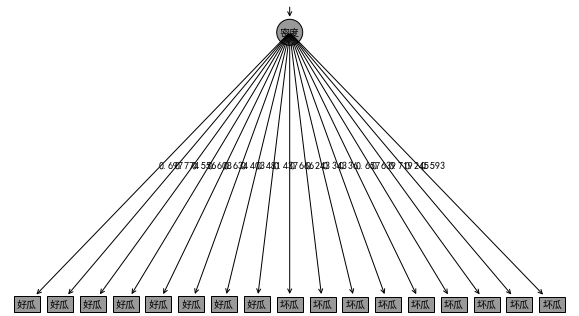

In [4]:
fealabel = ['色泽', '根蒂', '敲击', '纹理', '脐部', '触感', '密度', '含糖率']
sika_model_ID3 = DT_model.create_tree_ID3(data,fealabel)
print(sika_model_ID3)
DDT.createPlot(sika_model_ID3)

#### 使用C4.5生成决策树  
C4.5使用的是信息增益率，是ID3的改进

最佳划分特征(createtree) 纹理 3
最佳划分特征(createtree) 触感 4
最佳划分特征(createtree) 触感 4
最佳划分特征(createtree) 密度 4
{'纹理': {'稍糊': {'触感': {'硬滑': '坏瓜', '软粘': '好瓜'}}, '清晰': {'触感': {'软粘': {'密度': {0.40299999999999997: '好瓜', 0.24299999999999999: '坏瓜', 0.35999999999999999: '坏瓜'}}, '硬滑': '好瓜'}}, '模糊': '坏瓜'}}


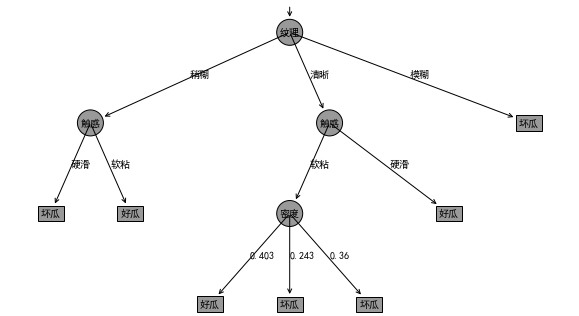

In [5]:
fealabel = ['色泽', '根蒂', '敲击', '纹理', '脐部', '触感', '密度', '含糖率']
sika_model = DT_model.create_tree_C45(data,fealabel)
print(sika_model)
DDT.createPlot(sika_model)

### 导入西瓜数据集2.0  
与3.0相比，只是去掉了密度和含糖率，我们用2.0再来看一下ID3和C4.5生成的树的差别

In [6]:
data = pd.read_csv("E://Desktop//DataSet//sika2.0.csv")
sika_feature=data.columns.values.tolist()[:6]#['色泽', '根蒂', '敲击', '纹理', '脐部', '触感']
DT_model = DecisionTree()
DDT = DrawDecisionTree()

最佳划分特征(createtree) 纹理 3
最佳划分特征(createtree) 触感 4
最佳划分特征(createtree) 根蒂 1
最佳划分特征(createtree) 色泽 0
最佳划分特征(createtree) 触感 2
{'纹理': {'稍糊': {'触感': {'硬滑': '坏瓜', '软粘': '好瓜'}}, '清晰': {'根蒂': {'蜷缩': '好瓜', '硬挺': '坏瓜', '稍蜷': {'色泽': {'乌黑': {'触感': {'软粘': '坏瓜', '硬滑': '好瓜'}}, '青绿': '好瓜'}}}}, '模糊': '坏瓜'}}


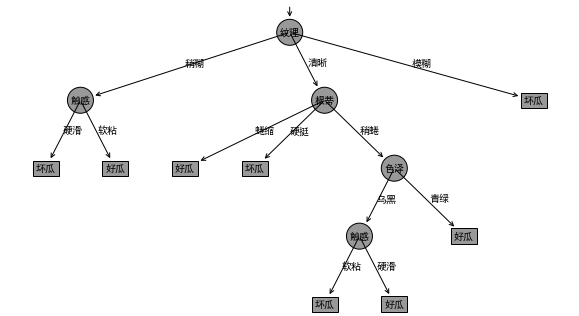

In [7]:
fealabel = ['色泽', '根蒂', '敲击', '纹理', '脐部', '触感']
sika_model = DT_model.create_tree_ID3(data,fealabel)
print(sika_model)
DDT.createPlot(sika_model)

最佳划分特征(createtree) 纹理 3
最佳划分特征(createtree) 触感 4
最佳划分特征(createtree) 触感 4
最佳划分特征(createtree) 色泽 0
最佳划分特征(createtree) 根蒂 0
{'纹理': {'稍糊': {'触感': {'硬滑': '坏瓜', '软粘': '好瓜'}}, '清晰': {'触感': {'软粘': {'色泽': {'乌黑': '坏瓜', '青绿': {'根蒂': {'硬挺': '坏瓜', '稍蜷': '好瓜'}}}}, '硬滑': '好瓜'}}, '模糊': '坏瓜'}}


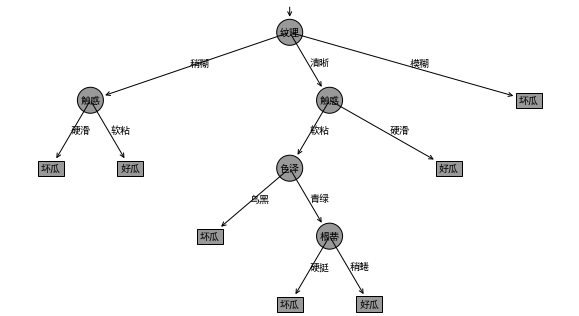

In [8]:
fealabel = ['色泽', '根蒂', '敲击', '纹理', '脐部', '触感']
sika_model = DT_model.create_tree_C45(data,fealabel)
print(sika_model)
DDT.createPlot(sika_model)